In [9]:
import numpy as np
import sys
import psi4
from helper_PFCI import PFHamiltonianGenerator
np.set_printoptions(threshold=sys.maxsize)
import scipy
from scipy.optimize import curve_fit
from scipy import interpolate
from matplotlib import pyplot as plt
from scipy import constants
from numpy.polynomial import Polynomial

In [10]:
mol_str = """
H
H 1 0.74
symmetry c1
"""

# options for the PFHamiltonian Generator class - include cavity effects
cavity_dict = {
    'omega_value' : 0.12086,
    'lambda_vector' : np.array([0, 0, 0.05]),
    'ci_level' : 'fci',   
    'full_diagonalization' : True,
    'number_of_photons' : 1, #<== this is a minimal photon basis, should explore increasing this 
}

# options for PFHamiltonian Generator class - exclude cavity effects
cavity_free_dict = {
    'omega_value' : 0.0,
    'lambda_vector' : np.array([0, 0, 0.0]),
    'ci_level' : 'fci',   
    'full_diagonalization' : True,
    'number_of_photons' : 0, }

# number of bondlengths in the scan
n = 200

# number of electronic states to save
N_el = 8

# array  for energies inside the cavity
cavity_E_array = np.zeros((n, N_el))


x_min = 0.5

x_max = 1

r_data = np.linspace(x_min, x_max, n)

In [11]:
mol_tmpl = """
H
H 1 **R**
symmetry c1
"""
options_dict = {
    "basis": "6-311G",
    "scf_type": "pk",
    "e_convergence": 1e-10,
    "d_convergence": 1e-10,
    'num_roots' : 2
}

psi4.set_options(options_dict)
fci_S0 = []
fci_S1 = []
r_idx = 0
for r in r_data:
    mol_str = mol_tmpl.replace("**R**", str(r))
    mol = psi4.geometry(mol_str)
    scf_e, wfn = psi4.energy('SCF', return_wfn=True)
    fci_energy, wfn = psi4.energy('fci',ref_wfn=wfn, return_wfn=True)
    fci_S0.append(wfn.variable("CI ROOT 0 TOTAL ENERGY"))
    fci_S1.append(wfn.variable("CI ROOT 1 TOTAL ENERGY"))
    cav = PFHamiltonianGenerator(mol_str, options_dict, cavity_dict)
    cavity_E_array[r_idx,:] = cav.CIeigs[:N_el]
    r_idx += 1


Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEM92KWMALT
*** at Thu Jan 18 16:19:12 2024

   => Loading Basis Set <=

    Name: 6-311G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1-2 entry H          line    21 file /Users/ptolley1/anaconda3/envs/work/share/psi4/basis/6-311g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c1
    Full point group: D_inf_h

    Geometry (in Angstrom), charg

Min on S0 is 0.7462311557788945
        5         4         3         2
-3.786 x + 16.81 x - 30.46 x + 28.39 x - 13.55 x + 1.469
533.8459022715164


<function matplotlib.pyplot.show(close=None, block=None)>

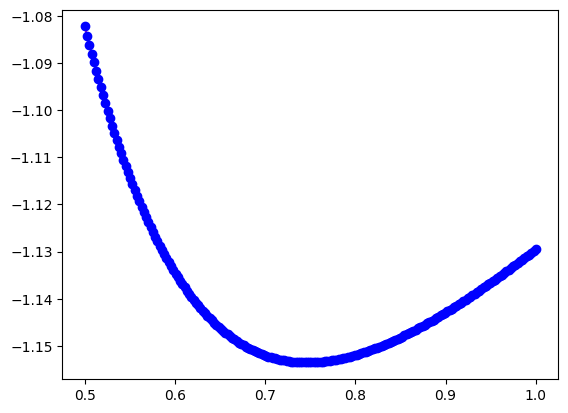

In [12]:
au_to_SI = (4.35974 * 10 ** (-18)) * 10 ** 20
min_S0_loc = np.argmin(fci_S0[:])
r_eq_ang = r_data[min_S0_loc]
print(f'Min on S0 is {r_data[min_S0_loc]}')

# Fitting S0 PES to a quintic polynomial
poly = np.poly1d(np.polyfit(r_data, fci_S0, 5))
print(poly)

#Taking first and second derivative of S0 PES and evaluating at r_eq
first_derivative = poly.deriv()
second_derivative = first_derivative.deriv()
k_test_au = second_derivative(r_eq_ang)
k_test_SI = k_test_au * au_to_SI
print(k_test_SI)

#plotting S0 PES and quintic fit
plt.plot(r_data, poly(r_data), 'm-', label='fit')
plt.plot(r_data, fci_S0[:], 'bo', label='cavity free |g>')
plt.show

In [68]:
r_eq_SI = r_eq_ang * 10 ** (-10)
r_eq_au = r_eq_ang * 1.88973
r_data_SI = r_data * 10 ** (-10)
r_data_au = r_data * 1.88973
delta_x_ang = x_max - x_min / n 
delta_x_au = delta_x_ang * 1.88973
length = (n - 1) * delta_x_au
mu = 1    #(1.007 * 1.007 / (1.007 + 1.007)) / (1000 * 6.022 * 10 ** 23)
h = 6.626 * 10 ** (-34)
hbar = 1 #scipy.constants.hbar
D_e_kJ_mol = 435.780 
D_e_J = D_e_kJ_mol * 1000 / (6.022* 10 ** 23)
D_e_H = D_e_J * 2.294 * 10 ** 17
a = np.sqrt(k_test_SI / (2 * D_e_J))
T_ij = np.zeros((n, n))
V_ij = np.zeros((n, n))
H_ij = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        for l in range(n-1):
            #T_l = (2 / mu) * (hbar * l / (2 * length)) ** 2
            T_ij[i,j] = np.cos(2 * np.pi * l * (r_data_au[i] - r_data_au[j] / (n - 1))) * (2 / mu) * (hbar * l / (2 * length)) ** 2
            V_ij[i,j] = 0.5 * (r_data_au[i] - r_eq_au) ** 2 * i==j
            #V_ij[i,j] = D_e_H * (1 - np.exp(-a * (r_data_SI[i] - r_eq_SI))) ** 2 * i==j
            H_ij = T_ij + V_ij
print(H_ij)

H_diag = np.linalg.eigh(H_ij)
eigenvalues = H_diag.eigenvalues
eigenvectors = H_diag.eigenvectors
#print(f'the eigenvales are {eigenvalues}')
print(f'the eigenvectors are {eigenvectors}')

[[ 1.08665303e+00  8.98520602e-02  9.29719285e-02  9.60098866e-02
   9.89632582e-02  1.01829441e-01  1.04605911e-01  1.07290220e-01
   1.09880005e-01  1.12372983e-01  1.14766959e-01  1.17059823e-01
   1.19249554e-01  1.21334225e-01  1.23311998e-01  1.25181130e-01
   1.26939975e-01  1.28586984e-01  1.30120706e-01  1.31539788e-01
   1.32842981e-01  1.34029137e-01  1.35097211e-01  1.36046262e-01
   1.36875453e-01  1.37584054e-01  1.38171441e-01  1.38637097e-01
   1.38980610e-01  1.39201679e-01  1.39300108e-01  1.39275811e-01
   1.39128810e-01  1.38859233e-01  1.38467319e-01  1.37953413e-01
   1.37317966e-01  1.36561540e-01  1.35684801e-01  1.34688521e-01
   1.33573577e-01  1.32340953e-01  1.30991733e-01  1.29527108e-01
   1.27948366e-01  1.26256900e-01  1.24454198e-01  1.22541850e-01
   1.20521541e-01  1.18395050e-01  1.16164250e-01  1.13831107e-01
   1.11397677e-01  1.08866103e-01  1.06238617e-01  1.03517532e-01
   1.00705246e-01  9.78042366e-02  9.48170599e-02  9.17463476e-02
   8.85948

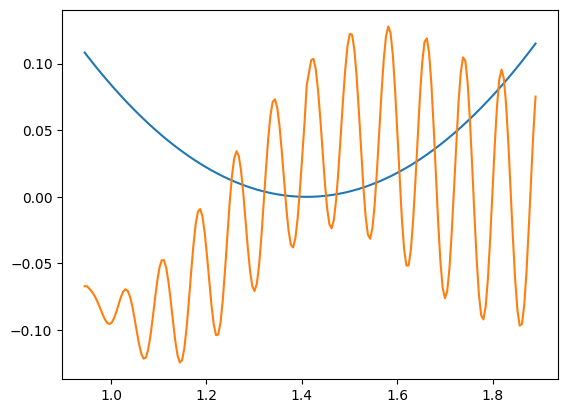

In [92]:
V_x = np.zeros((1,n))
for i in range(n):
    V_x[0,i] = 0.5 * (r_data_au[i] - r_eq_au) ** 2

eig_0 = np.zeros((1,n))
for i in range(n):
    eig_0[0,i] = eigenvalues[150]

plt.plot(r_data_au, V_x[0,:])
#plt.plot(r_data_au, eigenvalues)
plt.plot(r_data_au, eigenvectors[:,0])